In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Create a total spending feature
total_spending = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)

# Count the number of transactions per customer
transaction_counts = transactions.groupby('CustomerID')['TransactionID'].count().reset_index()
transaction_counts.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)

# Merge datasets
customer_data = customers.merge(total_spending, on='CustomerID', how='left') \
                          .merge(transaction_counts, on='CustomerID', how='left')

# Fill NaN values with 0 for customers with no transactions
customer_data['TotalSpending'].fillna(0, inplace=True)
customer_data['TransactionCount'].fillna(0, inplace=True)

# Select relevant features for clustering
features = customer_data[['TotalSpending', 'TransactionCount']]

In [4]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

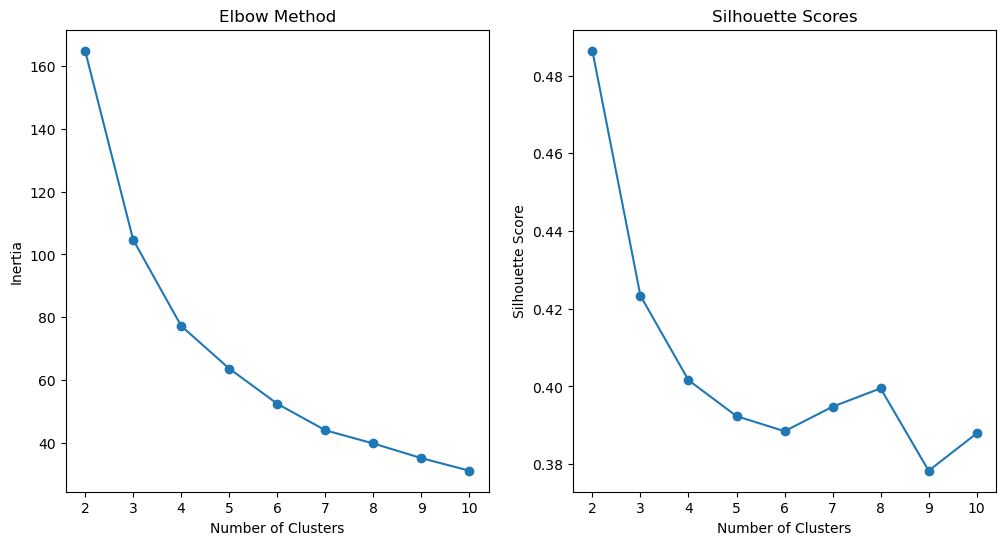

In [5]:
# Elbow Method to find the optimal number of clusters
inertia = []
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [6]:
# Fit KMeans with the chosen number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(features_scaled)

In [7]:
# Calculate clustering metrics
db_index = davies_bouldin_score(features_scaled, customer_data['Cluster'])
silhouette_avg = silhouette_score(features_scaled, customer_data['Cluster'])

print(f'Number of Clusters: {optimal_clusters}')
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

Number of Clusters: 4
Davies-Bouldin Index: 0.7993889477494841
Silhouette Score: 0.4016048814626258


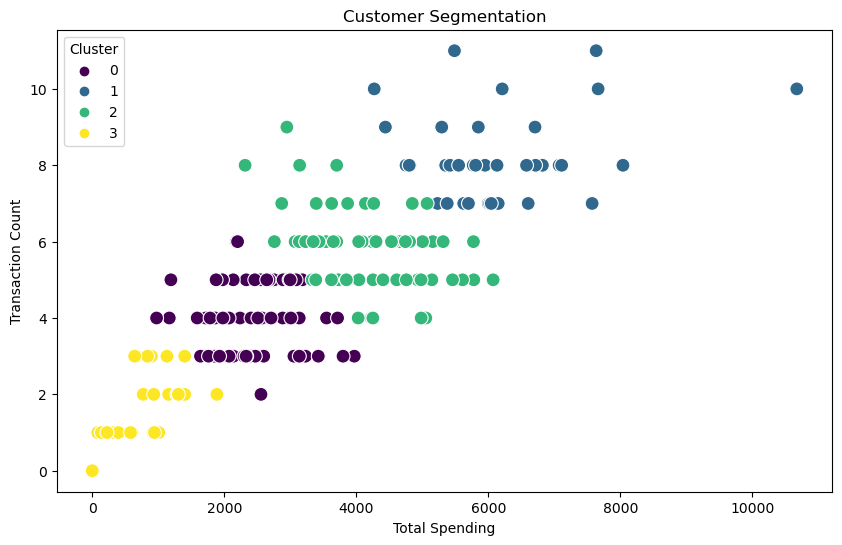

In [8]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features['TotalSpending'], y=features['TransactionCount'], hue=customer_data['Cluster'], palette='viridis', s=100)
plt.title('Customer Segmentation')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.show()

In [9]:
# Analyze the characteristics of each cluster
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpending': ['mean', 'count'],
    'TransactionCount': ['mean']
}).reset_index()

print(cluster_summary)

  Cluster TotalSpending       TransactionCount
                   mean count             mean
0       0   2497.625067    75         3.973333
1       1   6146.121944    36         8.222222
2       2   4183.431452    62         5.806452
3       3    816.316296    27         1.703704


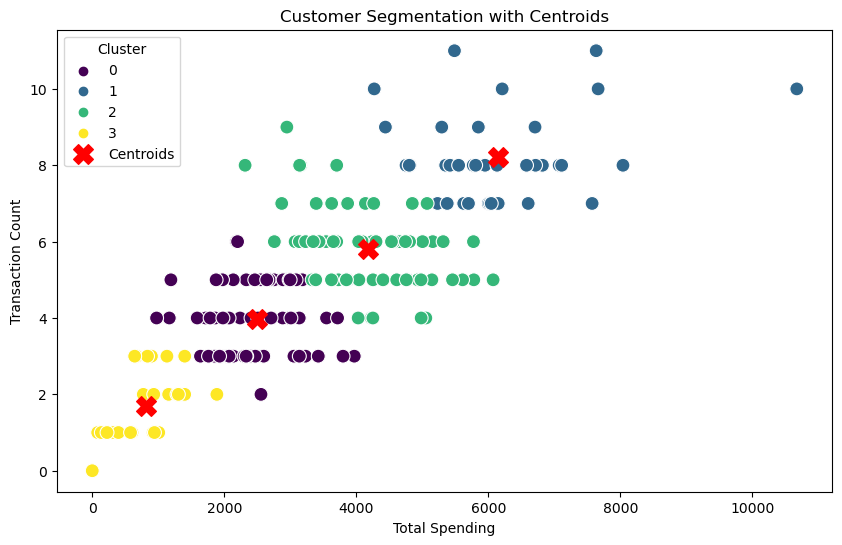

In [10]:
# Visualize the cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=['TotalSpending', 'TransactionCount'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=features['TotalSpending'], y=features['TransactionCount'], hue=customer_data['Cluster'], palette='viridis', s=100)
plt.scatter(centers_df['TotalSpending'], centers_df['TransactionCount'], color='red', s=200, marker='X', label='Centroids')
plt.title('Customer Segmentation with Centroids')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.show()